In [49]:
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from skimage.transform import resize
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input

In [50]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
physical_devices = tf.config.list_physical_devices('GPU')
if not physical_devices:
    pass
else:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [51]:
# モデルの作成（pretrained modelを使用する）
from tensorflow.keras.applications.resnet50 import ResNet50 as pretrained_model
from tensorflow.keras.applications.resnet50 import decode_predictions, preprocess_input

""" 別のpretrained modelを使用する用に 入力画像のサイズが変わったりするので注意
# VGG16 input_shape = (224,224,3)
from tensorflow.keras.applications.vgg16 import VGG16 as pretrained_model
from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

# InceptionV3 input_shape = (299,299,3)
from tensorflow.keras.applications.inception_v3 import InceptionV3 as pretrained_model
from tensorflow.keras.applications.inception_v3 import decode_predictions, preprocess_input

# EfficientNetB2  input_shape = (260,260,3)
from tensorflow.keras.applications.efficientnet import EfficientNetB2 as pretrained_model
from tensorflow.keras.applications.efficientnet import decode_predictions, preprocess_input
"""

model = pretrained_model(weights="imagenet")

In [52]:
# モデルの確認
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [53]:
# テストデータの用意
!mkdir input_images
!wget https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/input_images/spider.png?raw=true -O input_images/spider.png
!wget https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/input_images/dd_tree.jpg?raw=true -O input_images/dd_tree.jpg
!wget https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/input_images/snake.jpg?raw=true -O input_images/snake.jpg
!wget https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/input_images/cat_dog.png?raw=true -O input_images/cat_dog.png

mkdir: cannot create directory ‘input_images’: File exists
--2022-03-11 12:50:38--  https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/input_images/spider.png?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/utkuozbulak/pytorch-cnn-visualizations/raw/master/input_images/spider.png [following]
--2022-03-11 12:50:38--  https://github.com/utkuozbulak/pytorch-cnn-visualizations/raw/master/input_images/spider.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/input_images/spider.png [following]
--2022-03-11 12:50:38--  https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/input_images/spider.png
Resolving raw.githubusercontent.com (raw.githubusercontent

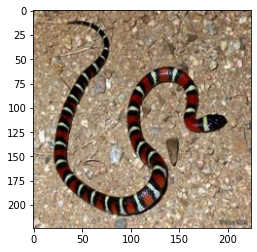

In [54]:
# テストデータの読み込みと確認
img_path = "input_images/snake.jpg" 
img_rgb = image.load_img(img_path,color_mode="rgb",target_size=(224,224))
img = image.img_to_array(img_rgb)
test_img = deepcopy(img)

plt.imshow(img / 255.)
plt.show()

In [55]:
# 予測結果
img = preprocess_input(img[np.newaxis,...])
preds = model.predict(img)

results = decode_predictions(preds,top=5)
[print(r) for r in results[0]]
print()

('n01734418', 'king_snake', 0.99157715)
('n01740131', 'night_snake', 0.008085571)
('n01728920', 'ringneck_snake', 8.6493485e-05)
('n01756291', 'sidewinder', 8.44777e-05)
('n01751748', 'sea_snake', 4.10923e-05)



In [56]:
# Grad-CAM
# Reference: https://keras.io/examples/vision/grad_cam/
def make_gradcam_heatmap(img,model,target_layer_name,pred_index=None):
    grad_model = tf.keras.Model(
        [model.inputs],[model.get_layer(target_layer_name).output,model.output]
    )
    
    with tf.GradientTape() as tape:
        target_layer_output, preds = grad_model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:,pred_index]
    
    grads = tape.gradient(class_channel,target_layer_output)
    pooled_grads = tf.reduce_mean(grads,axis=(0,1,2)) # αの計算
    
    heatmap = target_layer_output[0] @ pooled_grads[...,tf.newaxis] # α * A^k
    heatmap = tf.squeeze(heatmap)
    
    # ReLU and normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [57]:
# Grad-CAMの実行
target_layer_name = "conv5_block3_out"
heatmap = make_gradcam_heatmap(img,model,target_layer_name)

# 画像と同サイズにupsampling
# order=0 でただの拡大 order=1~5 で滑らかに拡大
gradcam = resize(heatmap,(224,224),order=1,mode="reflect",anti_aliasing=False)

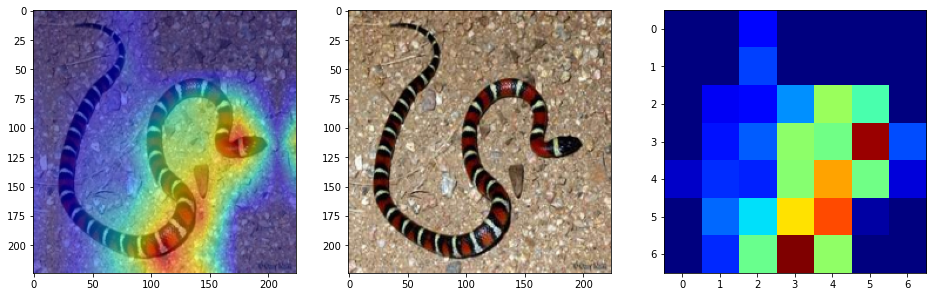

In [58]:
# Grad-CAMの結果表示
fig = plt.figure(figsize=(16,48))
fig.add_subplot(1,3,1)
plt.imshow(test_img / 255.)
plt.imshow(gradcam ,cmap="jet",alpha=0.5)
fig.add_subplot(1,3,2)
plt.imshow(test_img / 255.)
fig.add_subplot(1,3,3)
plt.imshow(heatmap,cmap="jet")
plt.show()